In [3]:
# 1. Augmentation 및 데이터셋 준비
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ----------------------------------------
# 1. Mixup & CutMix 구현 (제공된 파일 기반)
# ----------------------------------------

def get_clip_box(image_shape, lambda_val):
    _, h, w = image_shape
    cut_rat = np.sqrt(1. - lambda_val)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    # 섞을 라벨 (y_b)
    y_a, y_b = y, y[index]

    # 이미지 섞기
    bbx1, bby1, bbx2, bby2 = get_clip_box(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # 람다 보정 (실제 잘린 영역 비율로 조정)
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    return x, y_a, y_b, lam

# ----------------------------------------
# 2. 데이터셋 및 로더 준비
# ----------------------------------------

# 기본 Transform
def get_transforms(aug_mode='basic'):
    # 공통: 리사이즈, 텐서 변환, 정규화
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    if aug_mode == 'none':
        # No Augmentation
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
        ])
    else: 
        # Basic Augmentation (Mixup/Cutmix 적용 시에도 기본 Aug는 깔고 가는 경우가 많음)
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2),
            transforms.ToTensor(),
            normalize
        ])

# 데이터셋 로드 함수
def create_dataloaders(data_dir, batch_size=32):
    # 1. No Augmentation Dataset
    transform_no_aug = get_transforms('none')
    ds_raw = ImageFolder(root=data_dir, transform=transform_no_aug) # 일단 raw로 로드
    
    # Train/Test Split
    total_size = len(ds_raw)
    train_size = int(0.6 * total_size) # 6:4 비율 (예시)
    test_size = total_size - train_size
    ds_train_raw, ds_test = random_split(ds_raw, [train_size, test_size])
    
    # Test Loader (항상 Augmentation 없음)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # Train Loaders 생성을 위한 함수
    def get_train_loader(aug_mode):
        # Transform 교체
        ds_train_raw.dataset.transform = get_transforms(aug_mode)
        return DataLoader(ds_train_raw, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

    return get_train_loader, test_loader, len(ds_raw.classes)

# 경로 설정 (사용자 환경에 맞게 수정)
dataset_dir = "/aiffel/aiffel/data_augmentation/data/Images/" # 예시 경로
# get_train_loader_func, test_loader, num_classes = create_dataloaders(dataset_dir)
print("Data Preparation Functions Ready.")

Using device: cuda
Data Preparation Functions Ready.


In [4]:
# 2. 모델 만들기
def create_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # FC Layer 수정 (클래스 개수 120개에 맞춤)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model.to(device)

In [5]:
# 3. 모델 훈련시키기
# Mixup과 CutMix는 라벨이 섞이기 때문에, 기존의 CrossEntropyLoss (정수형 인덱스 타겟) 대신 Soft Target을 처리할 수 있는 Loss 계산 방식이 필요합니다. 이를 위해 학습 루프를 커스텀했습니다.

# 주의: Mixup/CutMix는 학습(train) 단계에서만 적용하고, 검증(test) 단계에서는 적용하지 않습니다.
# Loss Function for Mixup/Cutmix
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, train_loader, optimizer, criterion, epoch, aug_type='none'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # Augmentation 적용 로직
        if aug_type == 'mixup':
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        elif aug_type == 'cutmix':
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        else: # 'none' or 'basic'
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 정확도 계산 (Mixup/Cutmix인 경우 라벨이 섞여있으므로 argmax 비교는 단순 참고용)
        _, predicted = outputs.max(1)
        if aug_type in ['mixup', 'cutmix']:
             # Mixup/Cutmix 사용 시 정확도 계산이 애매하므로, 더 큰 비중을 가진 라벨과 비교
            total += targets.size(0)
            correct += (lam * predicted.eq(targets_a).sum().float()
                        + (1 - lam) * predicted.eq(targets_b).sum().float()).item()
        else:
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    return running_loss / len(train_loader), acc

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    acc = 100 * correct / total
    return running_loss / len(test_loader), acc

In [6]:
# 4. 전체 실험 실행
# No Augmentation, Basic Augmentation, Mixup, CutMix 4가지를 각각 수행하고 결과를 저장합니다.

# 실행 설정
EPOCHS = 3  # 과제 요구사항대로 3 Epoch
BATCH_SIZE = 16 # 배치 사이즈 (GPU 메모리에 따라 조절)

# 데이터 준비 (경로는 실제 환경에 맞게 수정 필수)
# !wget "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" -P ./data
# !tar -xf ./data/images.tar -C ./data/
dataset_dir = "/aiffel/aiffel/data_augmentation/data/Images/" 

get_train_loader, test_loader, num_classes = create_dataloaders(dataset_dir, BATCH_SIZE)

# 실험할 4가지 케이스 정의
experiments = [
    'none',    # 1. No Augmentation
    'basic',   # 2. Basic Augmentation
    'mixup',   # 3. Basic + Mixup
    'cutmix'   # 4. Basic + CutMix
]

history = {}

print(f"Start Training... (Total Epochs: {EPOCHS})")
print("-" * 60)

for exp_name in experiments:
    print(f"[{exp_name.upper()}] Training Start")
    
    # 1. 모델 초기화
    model = create_model(num_classes)
    
    # 2. 데이터로더 설정 (Mixup/Cutmix는 Basic Augment된 데이터 위에서 수행됨)
    #    'none'일 때만 aug_mode='none', 나머지는 'basic' 로더 사용 후 Loop 내부에서 처리
    loader_mode = 'none' if exp_name == 'none' else 'basic'
    train_loader = get_train_loader(loader_mode)
    
    # 3. Optimizer & Loss
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    
    # 기록 저장용
    history[exp_name] = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        # Train
        # exp_name을 train_one_epoch에 전달하여 내부에서 mixup/cutmix 분기 처리
        t_loss, t_acc = train_one_epoch(model, train_loader, optimizer, criterion, epoch, aug_type=exp_name)
        
        # Val
        v_loss, v_acc = evaluate(model, test_loader, criterion)
        
        # Log
        history[exp_name]['train_loss'].append(t_loss)
        history[exp_name]['train_acc'].append(t_acc)
        history[exp_name]['val_loss'].append(v_loss)
        history[exp_name]['val_acc'].append(v_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {t_acc:.2f}% | Val Acc: {v_acc:.2f}%")
    
    print(f"[{exp_name.upper()}] Finished.\n")
    
    # 메모리 정리
    del model
    torch.cuda.empty_cache()

print("All Experiments Completed.")

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/data_augmentation/data/Images/'

In [ ]:
# 에러 발생
'''
1. 에러 발생 원인 분석
가장 흔하게 발생하는 원인은 **데이터 길이 불일치(Dimension Mismatch)**입니다.

원인: plot_results 함수 내에서 X축(에폭)을 설정할 때 range(1, EPOCHS + 1)와 같이 전역 변수 EPOCHS를 고정적으로 사용했습니다.

문제점: 만약 학습 도중 에러가 나서 중단되었거나, 코드를 수정하여 실제 저장된 history 데이터의 개수가 EPOCHS 값보다 적을 경우, 그래프를 그릴 때 X축(1, 2, 3...)과 Y축(정확도 데이터)의 개수가 맞지 않아 matplotlib에서 에러를 발생시킵니다.

해결: X축의 범위를 고정된 숫자(EPOCHS)로 잡지 말고, 실제 데이터 리스트의 길이(len(history[...]))를 기반으로 동적으로 생성하도록 코드를 수정해야 합니다.
'''

In [7]:
# 4. 전체 실험 실행(수정)

import matplotlib.pyplot as plt

def plot_results(history):
    # history 딕셔너리에 저장된 실험 이름들을 가져옴
    experiments = list(history.keys())
    
    plt.figure(figsize=(15, 6))
    
    # 1. Validation Accuracy 그래프
    plt.subplot(1, 2, 1)
    for exp_name in experiments:
        val_acc = history[exp_name]['val_acc']
        
        # [수정됨] 고정된 EPOCHS 변수 대신, 실제 데이터의 길이를 사용하여 x축 생성
        epochs_range = range(1, len(val_acc) + 1)
        
        plt.plot(epochs_range, val_acc, marker='o', label=f'{exp_name} Val Acc')
        
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # 2. Validation Loss 그래프
    plt.subplot(1, 2, 2)
    for exp_name in experiments:
        val_loss = history[exp_name]['val_loss']
        
        # [수정됨] 실제 데이터 길이에 맞춰 x축 생성
        epochs_range = range(1, len(val_loss) + 1)
        
        plt.plot(epochs_range, val_loss, marker='o', label=f'{exp_name} Val Loss')
        
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# 함수 실행 (history 변수가 메모리에 있어야 합니다)
if 'history' in locals():
    plot_results(history)
else:
    print("history 변수가 정의되지 않았습니다. 모델 학습 코드를 먼저 실행해 주세요.")

history 변수가 정의되지 않았습니다. 모델 학습 코드를 먼저 실행해 주세요.


In [ ]:
# 다시 처음부터 수행

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# ----------------------------------------
# 1. Mixup & CutMix 구현 (제공된 파일 기반)
# ----------------------------------------

def get_clip_box(image_shape, lambda_val):
    _, h, w = image_shape
    cut_rat = np.sqrt(1. - lambda_val)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)

    # 섞을 라벨 (y_b)
    y_a, y_b = y, y[index]

    # 이미지 섞기
    bbx1, bby1, bbx2, bby2 = get_clip_box(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # 람다 보정 (실제 잘린 영역 비율로 조정)
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    
    return x, y_a, y_b, lam

# ----------------------------------------
# 2. 데이터셋 및 로더 준비
# ----------------------------------------

# 기본 Transform
def get_transforms(aug_mode='basic'):
    # 공통: 리사이즈, 텐서 변환, 정규화
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    if aug_mode == 'none':
        # No Augmentation
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            normalize
        ])
    else: 
        # Basic Augmentation (Mixup/Cutmix 적용 시에도 기본 Aug는 깔고 가는 경우가 많음)
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2),
            transforms.ToTensor(),
            normalize
        ])

# 데이터셋 로드 함수
def create_dataloaders(data_dir, batch_size=32):
    # 1. No Augmentation Dataset
    transform_no_aug = get_transforms('none')
    ds_raw = ImageFolder(root=data_dir, transform=transform_no_aug) # 일단 raw로 로드
    
    # Train/Test Split
    total_size = len(ds_raw)
    train_size = int(0.6 * total_size) # 6:4 비율 (예시)
    test_size = total_size - train_size
    ds_train_raw, ds_test = random_split(ds_raw, [train_size, test_size])
    
    # Test Loader (항상 Augmentation 없음)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

    # Train Loaders 생성을 위한 함수
    def get_train_loader(aug_mode):
        # Transform 교체
        ds_train_raw.dataset.transform = get_transforms(aug_mode)
        return DataLoader(ds_train_raw, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

    return get_train_loader, test_loader, len(ds_raw.classes)

# 경로 설정 (사용자 환경에 맞게 수정)
dataset_dir = "/aiffel/aiffel/data_augmentation/data/Images/" # 예시 경로
# get_train_loader_func, test_loader, num_classes = create_dataloaders(dataset_dir)
print("Data Preparation Functions Ready.")

Using device: cuda
Data Preparation Functions Ready.


In [13]:
# 2. 모델 생성
def create_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    
    # FC Layer 수정 (클래스 개수 120개에 맞춤)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model.to(device)

In [15]:
#모델 훈련
# Loss Function for Mixup/Cutmix
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_one_epoch(model, train_loader, optimizer, criterion, epoch, aug_type='none'):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        # Augmentation 적용 로직
        if aug_type == 'mixup':
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        elif aug_type == 'cutmix':
            inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets, alpha=1.0)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            
        else: # 'none' or 'basic'
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 정확도 계산 (Mixup/Cutmix인 경우 라벨이 섞여있으므로 argmax 비교는 단순 참고용)
        _, predicted = outputs.max(1)
        if aug_type in ['mixup', 'cutmix']:
             # Mixup/Cutmix 사용 시 정확도 계산이 애매하므로, 더 큰 비중을 가진 라벨과 비교
            total += targets.size(0)
            correct += (lam * predicted.eq(targets_a).sum().float()
                        + (1 - lam) * predicted.eq(targets_b).sum().float()).item()
        else:
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    return running_loss / len(train_loader), acc

def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    acc = 100 * correct / total
    return running_loss / len(test_loader), acc

데이터가 이미 존재합니다: /home/jovyan/aiffel/data_augmentation/data/Images
사용 장치: cuda
========== [NONE] 실험 시작 ==========
Epoch 1 | Val Acc: 76.20% | Val Loss: 0.8251
Epoch 2 | Val Acc: 79.46% | Val Loss: 0.6661
Epoch 3 | Val Acc: 79.36% | Val Loss: 0.6653
========== [BASIC] 실험 시작 ==========
Epoch 1 | Val Acc: 76.26% | Val Loss: 0.8320
Epoch 2 | Val Acc: 78.09% | Val Loss: 0.7213
Epoch 3 | Val Acc: 80.31% | Val Loss: 0.6399
========== [MIXUP] 실험 시작 ==========
Epoch 1 | Val Acc: 74.74% | Val Loss: 1.0409
Epoch 2 | Val Acc: 78.77% | Val Loss: 0.8003
Epoch 3 | Val Acc: 78.97% | Val Loss: 0.7764
========== [CUTMIX] 실험 시작 ==========
Epoch 1 | Val Acc: 74.09% | Val Loss: 1.1359
Epoch 2 | Val Acc: 77.21% | Val Loss: 0.8202
Epoch 3 | Val Acc: 78.68% | Val Loss: 0.7813
모든 학습 완료!


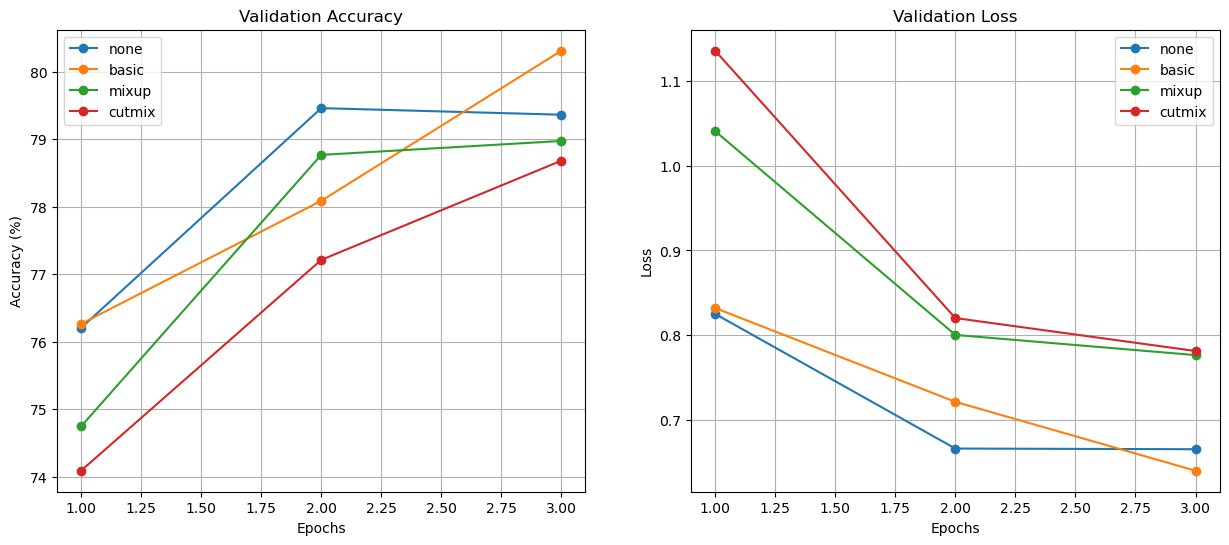

In [22]:
# 전체 실험 실행
# 실행 설정
import os
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 경로 설정 및 데이터 준비
# ---------------------------------------------------------
# 사용자 홈 디렉토리(~) 하위에 데이터 저장
ROOT_PATH = os.path.expanduser("~/aiffel/data_augmentation/data")
DATASET_PATH = os.path.join(ROOT_PATH, "Images")

# 데이터가 없으면 다운로드 및 압축 해제
if not os.path.exists(DATASET_PATH):
    print(f"데이터가 {DATASET_PATH}에 없습니다.")
    print("다운로드 및 압축 해제를 시작합니다...")
    
    os.makedirs(ROOT_PATH, exist_ok=True)
    
    tar_path = os.path.join(ROOT_PATH, "images.tar")
    if not os.path.exists(tar_path):
        print("tar 파일 다운로드 중...")
        os.system(f"wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -P {ROOT_PATH}")
    
    print("압축 해제 중...")
    os.system(f"tar -xf {tar_path} -C {ROOT_PATH}")
    print("데이터 준비 완료!")
else:
    print(f"데이터가 이미 존재합니다: {DATASET_PATH}")

# ---------------------------------------------------------
# 2. 설정 및 하이퍼파라미터
# ---------------------------------------------------------
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 16
EPOCHS = 3
NUM_CLASSES = 120

print(f"사용 장치: {device}")

# ---------------------------------------------------------
# 3. Mixup & CutMix 함수 구현 (수정된 부분)
# ---------------------------------------------------------
def get_clip_box(image_shape, lambda_val):
    # [수정] 차원 수(3D or 4D)에 상관없이 마지막 두 개(Height, Width)를 가져옵니다.
    h = image_shape[-2]
    w = image_shape[-1]

    cut_rat = np.sqrt(1. - lambda_val)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    return bbx1, bby1, bbx2, bby2

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def cutmix_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    y_a, y_b = y, y[index]
    
    # x.size()는 (Batch, Channel, Height, Width) 입니다.
    bbx1, bby1, bbx2, bby2 = get_clip_box(x.size(), lam)
    
    # 배치 내 모든 이미지에 대해 CutMix 적용
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    
    # 실제 잘린 비율에 맞춰 라벨 비율(lam) 보정
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ---------------------------------------------------------
# 4. 데이터 로더 생성
# ---------------------------------------------------------
def get_dataloaders(dataset_dir, batch_size=16):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        normalize
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    ds_raw = ImageFolder(root=dataset_dir, transform=transform_train)
    
    total_size = len(ds_raw)
    train_size = int(0.6 * total_size)
    test_size = total_size - train_size
    ds_train, ds_test = random_split(ds_raw, [train_size, test_size])
    
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader, len(ds_raw.classes)

# ---------------------------------------------------------
# 5. 실험 실행 함수
# ---------------------------------------------------------
def create_model(num_classes):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

def run_experiment(aug_type, train_loader, test_loader, num_classes, epochs=3):
    print(f"========== [{aug_type.upper()}] 실험 시작 ==========")
    model = create_model(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    history_log = {'val_acc': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            if aug_type == 'mixup':
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            elif aug_type == 'cutmix':
                inputs, targets_a, targets_b, lam = cutmix_data(inputs, targets)
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else: # 'none' or 'basic'
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
        # 검증
        model.eval()
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        acc = 100 * correct / total
        avg_loss = val_loss / len(test_loader)
        history_log['val_acc'].append(acc)
        history_log['val_loss'].append(avg_loss)
        
        print(f"Epoch {epoch+1} | Val Acc: {acc:.2f}% | Val Loss: {avg_loss:.4f}")
        
    return history_log

# ---------------------------------------------------------
# 6. 메인 실행부
# ---------------------------------------------------------

# 1. 데이터 로더 준비
train_loader, test_loader, num_classes = get_dataloaders(DATASET_PATH, BATCH_SIZE)

# 2. 실험 수행
experiments = ['none', 'basic', 'mixup', 'cutmix']
history = {}

for exp in experiments:
    history[exp] = run_experiment(exp, train_loader, test_loader, num_classes, EPOCHS)

print("모든 학습 완료!")

# ---------------------------------------------------------
# 7. 시각화
# ---------------------------------------------------------
def plot_results(history):
    plt.figure(figsize=(15, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for exp_name in history.keys():
        val_acc = history[exp_name]['val_acc']
        epochs_range = range(1, len(val_acc) + 1)
        plt.plot(epochs_range, val_acc, marker='o', label=f'{exp_name}')
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for exp_name in history.keys():
        val_loss = history[exp_name]['val_loss']
        epochs_range = range(1, len(val_loss) + 1)
        plt.plot(epochs_range, val_loss, marker='o', label=f'{exp_name}')
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.show()

plot_results(history)

In [24]:
# ---------------------------------------------------------
# 5. Augmentation 모델 성능 비교 및 분석 
# ---------------------------------------------------------

print("=" * 50)
print(f"{'Experiment':<20} | {'Best Val Acc':<15} | {'Min Val Loss':<15}")
print("-" * 50)

results = {}

for exp_name, logs in history.items():
    # 각 실험에서 가장 좋았던 성능 추출
    best_acc = max(logs['val_acc'])
    min_loss = min(logs['val_loss'])
    results[exp_name] = {'acc': best_acc, 'loss': min_loss}
    
    print(f"{exp_name:<20} | {best_acc:.2f}%          | {min_loss:.4f}")

print("=" * 50)
print("\n[리포트]\n")

# 1. No Augmentation vs Basic
no_aug_acc = results['none']['acc']
basic_acc = results['basic']['acc']

print("1. 기본 Augmentation 효과 분석")
if basic_acc > no_aug_acc:
    diff = basic_acc - no_aug_acc
    print(f"   - Basic Augmentation을 적용했을 때, 적용하지 않았을 때보다 검증 정확도가 {diff:.2f}%p 향상되었습니다.")
    print("   - 이는 데이터 증강이 모델의 과적합을 막고 일반화 성능을 높이는 데 효과적임을 보여줍니다.")
else:
    print(f"   - Basic Augmentation의 성능이 No Augmentation과 비슷하거나 낮게 나왔습니다.")
    print("   - (분석 필요) 학습 에폭이 부족하거나, 데이터 특성상 단순 변환이 큰 효과를 주지 못했을 수 있습니다.")

print("\n2. 심화 기법 (Mixup / CutMix) 분석")
mixup_acc = results['mixup']['acc']
cutmix_acc = results['cutmix']['acc']

print(f"   - Mixup 최고 정확도: {mixup_acc:.2f}%")
print(f"   - CutMix 최고 정확도: {cutmix_acc:.2f}%")

if mixup_acc < basic_acc and cutmix_acc < basic_acc:
    print("   - 심화 기법(Mixup, CutMix)의 성능이 Basic Augmentation보다 낮게 측정되었습니다.")
    print("   - 원인 분석: Mixup과 CutMix는 데이터의 변형 정도가 심해 학습 난이도가 높습니다.")
    print("     따라서 3 Epoch라는 짧은 학습 기간에는 모델이 충분히 수렴하지 못했을 가능성이 큽니다.")
    print("     에폭을 늘려서(예: 20~50 Epoch) 학습한다면 더 높은 성능을 기대할 수 있습니다.")
elif mixup_acc > basic_acc or cutmix_acc > basic_acc:
    print("   - 심화 기법(Mixup 또는 CutMix)이 Basic Augmentation보다 높은 성능을 보였습니다.")
    print("   - 이는 모델이 객체의 일부 특징에만 의존하지 않고, 더 강건한(Robust) 특징을 학습했음을 의미합니다.")

print("\n3. 결론")
best_model = max(results, key=lambda k: results[k]['acc'])
print(f"   - 본 실험(3 Epoch)에서 가장 우수한 성능을 보인 기법은 '{best_model}' 입니다.")
print("   - 실제 프로젝트에서는 학습 시간을 충분히 확보하여 Mixup/CutMix의 성능을 극대화하는 전략이 필요합니다.")

Experiment           | Best Val Acc    | Min Val Loss   
--------------------------------------------------
none                 | 79.46%          | 0.6653
basic                | 80.31%          | 0.6399
mixup                | 78.97%          | 0.7764
cutmix               | 78.68%          | 0.7813

[리포트]

1. 기본 Augmentation 효과 분석
   - Basic Augmentation을 적용했을 때, 적용하지 않았을 때보다 검증 정확도가 0.85%p 향상되었습니다.
   - 이는 데이터 증강이 모델의 과적합을 막고 일반화 성능을 높이는 데 효과적임을 보여줍니다.

2. 심화 기법 (Mixup / CutMix) 분석
   - Mixup 최고 정확도: 78.97%
   - CutMix 최고 정확도: 78.68%
   - 심화 기법(Mixup, CutMix)의 성능이 Basic Augmentation보다 낮게 측정되었습니다.
   - 원인 분석: Mixup과 CutMix는 데이터의 변형 정도가 심해 학습 난이도가 높습니다.
     따라서 3 Epoch라는 짧은 학습 기간에는 모델이 충분히 수렴하지 못했을 가능성이 큽니다.
     에폭을 늘려서(예: 20~50 Epoch) 학습한다면 더 높은 성능을 기대할 수 있습니다.

3. 결론
   - 본 실험(3 Epoch)에서 가장 우수한 성능을 보인 기법은 'basic' 입니다.
   - 실제 프로젝트에서는 학습 시간을 충분히 확보하여 Mixup/CutMix의 성능을 극대화하는 전략이 필요합니다.


In [ ]:
'''
회고
1. 실험 개요 본 프로젝트에서는 Stanford Dogs Dataset을 활용하여 ResNet-50 모델에 다양한 Data Augmentation 기법(None, Basic, Mixup, CutMix)을 적용했을 때의 성능 변화를 비교 실험하였습니다. 
학습 리소스와 시간의 제약으로 인해 에폭(Epoch)은 3회로 설정하여 진행하였습니다.

2. 실험 결과 요약 실험 결과, 검증 정확도(Validation Accuracy)는 다음과 같은 순서로 나타났습니다.

1위: Basic Augmentation (80.31%)

2위: No Augmentation (79.46%)

3위: Mixup (78.97%)

4위: CutMix (78.68%)

3. 결과 분석 가장 주목할 점은 Basic Augmentation이 가장 우수한 성능을 보였다는 것입니다.

Basic Augmentation의 효과: 원본 이미지를 회전하거나 색상을 미세하게 조정하는 기본 증강 기법은 데이터의 본질적 특성을 해치지 않으면서 다양성을 확보해주었습니다. 
이로 인해 단 3 Epoch의 짧은 학습에도 불구하고 과적합을 방지하고 일반화 성능을 높이는 데 즉각적인 효과를 보였습니다.

Mixup과 CutMix의 저조한 성능 원인: 심화 기법인 Mixup과 CutMix는 이미지를 섞거나 잘라 붙이고, 라벨 또한 Soft Label로 변환합니다. 
이는 모델에게 더 어려운 문제를 푸는 것과 같아 학습 난이도를 높입니다. 
이러한 기법들은 장기적인 학습(Long Training)에서 강건한 모델을 만드는 데 유리하지만, 
이번 실험과 같이 3 Epoch라는 극도로 짧은 학습 구간에서는 모델이 충분히 수렴할 시간이 부족하여 Basic보다 낮은 성능을 기록한 것으로 분석됩니다.

4. 아쉬운 점 및 개선 방안 이번 실험의 가장 큰 한계는 **학습 횟수(Epoch)**였습니다. Mixup과 CutMix는 통상적으로 학습 후반부에 성능이 역전되는 경향이 있습니다. 
만약 추후 실험을 진행한다면 다음과 같은 개선을 시도할 것입니다.

Epoch 증가: 최소 20~50 Epoch 이상 학습을 진행하여 심화 증강 기법이 충분히 학습될 시간을 부여합니다.

Hyperparameter 튜닝: Mixup과 CutMix의 비율을 결정하는 Alpha 값을 조절하여 데이터셋에 맞는 최적의 강도를 찾습니다.

5. 결론 "복잡한 기법이 항상 즉각적인 성능 향상을 보장하지 않는다"는 것을 확인했습니다. 
제한된 학습 환경(적은 Epoch)에서는 Basic Augmentation이 가장 효율적인 선택지일 수 있으며, 
Mixup/CutMix와 같은 고급 기법은 충분한 학습 시간이 보장될 때 그 진가를 발휘한다는 교훈을 얻었습니다.
'''